# SENSTIVITY ANALYSIS

In [226]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from itertools import permutations
import warnings
warnings.filterwarnings("ignore")

In [227]:
## DEFINING HELPER FUNCTIONS FOR NORMALIZATION
def minNormalize(values):
    values = list(values)
    goal = values.pop(-1)
    normal = [9*((max(values)-x)/(max(values)-min(values)))+1 for x in values]
    normal.append(goal)
    return normal

def maxNormalize(values):
    values = list(values)
    goal = values.pop(-1)
    normal = [9*((x-min(values))/(max(values)-min(values)))+1 for x in values]
    normal.append(goal)
    return normal

def normalize(values):
    if values.iloc[-1] == 'MAX':
        normal = maxNormalize(values)
    else:
        normal = minNormalize(values)
    return normal

## DEFINING HELPER FUNCTION FOR GETTING WEIGHTED SUM
def getWeightedSum(values):
    values = list(values)
    weight = values.pop(0)
    values = [value*weight for value in values]
    values.insert(0, weight)
    return values

def getTotal(values):
    return sum(values)

## SINGLE EXECUTION

In [228]:
criteria = ['FLOPS','Inference Time','Coeffecient of Determination','Storage Consumption','Training Time']
levelOfImportance = [7,9,10,8,6]
weight = [(level/sum(levelOfImportance)) for level in levelOfImportance]
NestedUNet = [1892644106,
              143.5163,
              0.8740,
              672.0036,
              203.8519]
SegNet = [4288301206,
          137.4168,
          0.8971,
          326.1677,
          447.6633]
DeepLabV3Plus = [5460291464,
                 181.956,
                 0.8910,
                 269.1062,
                 242.0727]
goal = ['MIN','MIN','MAX','MIN','MIN'] #'MIN','MIN','MAX','MIN','MAX'

In [229]:
data = pd.DataFrame({'levelOfImportance':levelOfImportance,
                     'weight':weight,
                     'NestedUNet':NestedUNet,
                     'SegNet':SegNet,
                     'DeepLabV3Plus':DeepLabV3Plus,
                     },
                     index = criteria)
data.index.name='criteria'
data = data.map(lambda x: float(x))
data['goal'] = goal

In [230]:
## NORMALIZING DATA
for i in range(data.shape[0]):
    data.iloc[i,2:] = normalize(data.iloc[i,2:])

In [231]:
## GETTING WEIGHTED SUM
for i in range(data.shape[0]):
    data.iloc[i,1:-1] = getWeightedSum(data.iloc[i,1:-1])


In [232]:
## GETTING totals
total=[]
for i in range(5):
    total.append(getTotal(data.iloc[:,i]))
total.append(None)
data.loc[len(data)] = total
index = [idx for idx in data.index][:-1]
index.append('total')
data = data.set_index([index])

In [233]:
data

,levelOfImportance,weight,NestedUNet,SegNet,DeepLabV3Plus,goal
FLOPS,7.0,0.175,1.750000,0.692395,0.175000,MIN
Inference Time,9.0,0.225,1.972683,2.250000,0.225000,MIN
Coeffecient of Determination,10.0,0.250,0.250000,2.500000,1.905844,MAX
Storage Consumption,8.0,0.200,0.200000,1.745070,2.000000,MIN
Training Time,6.0,0.150,1.500000,0.150000,1.288369,MIN
total,40.0,1.000,5.672683,7.337465,5.594213,NaN


In [234]:
levels = permutations(levelOfImportance)
print(list(next(levels)))

[7, 9, 10, 8, 6]


## 120 EXECUTIONS

In [235]:
levels = permutations(levelOfImportance)
design1 = []
design2 = []
design3 = []
weights = []
for level in levels:
    ## DECALRING VALUES
    criteria = criteria
    level = list(level)
    weight = [(l/sum(level)) for l in level]
    goal = ['MIN','MIN','MAX','MIN','MIN']

    ## CREATING DATAFRAME
    data = pd.DataFrame({'levelOfImportance':levelOfImportance,
                        'weight':weight,
                        'NestedUNet':NestedUNet,
                        'SegNet':SegNet,
                        'DeepLabV3Plus':DeepLabV3Plus,
                        },
                        index = criteria)
    data.index.name='criteria'
    data = data.map(lambda x: float(x))
    data['goal'] = goal

    ## NORMALIZING DATA
    for i in range(data.shape[0]):
        data.iloc[i,2:] = normalize(data.iloc[i,2:])

    ## GETTING WEIGHTED SUM
    for i in range(data.shape[0]):
        data.iloc[i,1:-1] = getWeightedSum(data.iloc[i,1:-1])


    # ## GETTING totals
    total=[]
    for i in range(5):
        total.append(getTotal(data.iloc[:,i]))
    total.append(None)
    data.loc[len(data)] = total
    index = [idx for idx in data.index][:-1]
    index.append('total')
    data = data.set_index([index])
    weights.append([level,data.iloc[:-1,1].values])
    design1.append(data.iloc[-1,2])
    design2.append(data.iloc[-1,3])
    design3.append(data.iloc[-1,4])



In [236]:
import random
values = [6,7,8,9,10]
permutations = []
for i in range(10):
    random.shuffle(values)
    permutations.append(values)

In [237]:
np.array(weights)[::12,0].astype(int)

array([[ 7,  9, 10,  8,  6],
       [ 7,  8,  9, 10,  6],
       [ 9,  7, 10,  8,  6],
       [ 9,  8,  7, 10,  6],
       [10,  7,  9,  8,  6],
       [10,  8,  7,  9,  6],
       [ 8,  7,  9, 10,  6],
       [ 8, 10,  7,  9,  6],
       [ 6,  7,  9, 10,  8],
       [ 6, 10,  7,  9,  8]])

In [238]:
## PRINTING RESULTS OF ANALYSIS
for n,weight in enumerate(weights):
    print("Permutation",n,':',weight[0])
    print("Weights",':',weight[1])
    print(" Design 1 =",design1[n])
    print(" Design 2 =",design2[n])
    print(" Design 3 =",design3[n])
    print('')

Permutation 0 : [7, 9, 10, 8, 6]
Weights : [0.175 0.225 0.25  0.2   0.15 ]
 Design 1 = 5.672682771580989
 Design 2 = 7.337465327594231
 Design 3 = 5.594213034411771

Permutation 1 : [7, 9, 10, 6, 8]
Weights : [0.175 0.225 0.25  0.15  0.2  ]
 Design 1 = 6.1226827715809895
 Design 2 = 6.951197868434653
 Design 3 = 5.523669327267642

Permutation 2 : [7, 9, 8, 10, 6]
Weights : [0.175 0.225 0.2   0.25  0.15 ]
 Design 1 = 5.672682771580989
 Design 2 = 7.273732786753808
 Design 3 = 5.713044203242939

Permutation 3 : [7, 9, 8, 6, 10]
Weights : [0.175 0.225 0.2   0.15  0.25 ]
 Design 1 = 6.57268277158099
 Design 2 = 6.5011978684346525
 Design 3 = 5.571956788954682

Permutation 4 : [7, 9, 6, 10, 8]
Weights : [0.175 0.225 0.15  0.25  0.2  ]
 Design 1 = 6.122682771580989
 Design 2 = 6.823732786753808
 Design 3 = 5.76133166492998

Permutation 5 : [7, 9, 6, 8, 10]
Weights : [0.175 0.225 0.15  0.2   0.25 ]
 Design 1 = 6.572682771580989
 Design 2 = 6.43746532759423
 Design 3 = 5.690787957785851

Permu

In [239]:
## PRINTING RESULTS OF ANALYSIS
for n,weight in enumerate(weights):
    if n%24!=0 and n>0:
        
        print("Permutation",n-24,'to',n,':',weight[0])
        print("Weights",':',weight[1])
        print(" Design 1 =",design1[n])
        print(" Design 2 =",design2[n])
        print(" Design 3 =",design3[n])
        print('')

Permutation -23 to 1 : [7, 9, 10, 6, 8]
Weights : [0.175 0.225 0.25  0.15  0.2  ]
 Design 1 = 6.1226827715809895
 Design 2 = 6.951197868434653
 Design 3 = 5.523669327267642

Permutation -22 to 2 : [7, 9, 8, 10, 6]
Weights : [0.175 0.225 0.2   0.25  0.15 ]
 Design 1 = 5.672682771580989
 Design 2 = 7.273732786753808
 Design 3 = 5.713044203242939

Permutation -21 to 3 : [7, 9, 8, 6, 10]
Weights : [0.175 0.225 0.2   0.15  0.25 ]
 Design 1 = 6.57268277158099
 Design 2 = 6.5011978684346525
 Design 3 = 5.571956788954682

Permutation -20 to 4 : [7, 9, 6, 10, 8]
Weights : [0.175 0.225 0.15  0.25  0.2  ]
 Design 1 = 6.122682771580989
 Design 2 = 6.823732786753808
 Design 3 = 5.76133166492998

Permutation -19 to 5 : [7, 9, 6, 8, 10]
Weights : [0.175 0.225 0.15  0.2   0.25 ]
 Design 1 = 6.572682771580989
 Design 2 = 6.43746532759423
 Design 3 = 5.690787957785851

Permutation -18 to 6 : [7, 10, 9, 8, 6]
Weights : [0.175 0.25  0.225 0.2   0.15 ]
 Design 1 = 5.866869746201099
 Design 2 = 7.3374653275

Text(0.5, 1.0, 'Summary of Sensitivity Analysis')

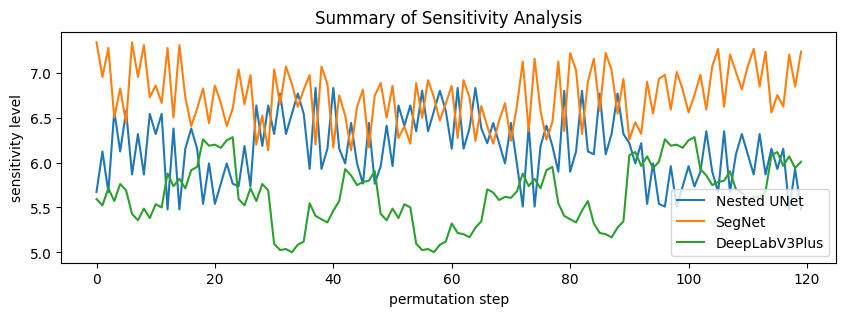

In [240]:
## PLOTTING RESULTS OF ANALYSIS
x=range(len(weights))
f, ax = plt.subplots(1,1, figsize=(10,3))
sns.lineplot(x=x, y=design1, ax = ax, label = 'Nested UNet')
sns.lineplot(x=x, y=design2, ax = ax, label = 'SegNet')
sns.lineplot(x=x, y=design3, ax = ax, label = 'DeepLabV3Plus')
ax.set_ylabel('sensitivity level')
ax.set_xlabel('permutation step')
ax.set_title('Summary of Sensitivity Analysis')

In [241]:
## Creating radar graph

iterations = [str(i) for i in range(120)]

#design 1
data1=go.Scatterpolar(
      r=design1,
      theta=iterations,
      # fill='toself',
      name='Design 1: Nested UNet',
)

#design 2
data2=go.Scatterpolar(
      r=design2,
      theta=iterations,
      # fill='toself',
      name='Design 2: SegNet'
)

#design 3
data3 = go.Scatterpolar(
      r=design3,
      theta=iterations,
      # fill='toself',
      name='Design 3: DeepLabV3+'
)

datas = [data1,data2,data3]

# #customization of chart
# fig.update_layout(
#   polar=dict(
#     radialaxis=dict(
#       visible=True,
#       range=[1, 10]
#     )),
#   showlegend=False
# )

layout = go.Layout(
        plot_bgcolor='rgba(0,0,0,0)',
        legend=dict(
            x=0,
            y=1.1,
            traceorder='normal',
            font=dict(
                size=12,),
        ),
    annotations=[
        dict(
            x=0,
            y=0.75,
            xref='paper',
            yref='paper',
            text='',
            showarrow=False
        )
    ],
    autosize=False,
    width=900,
    height=700,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

fig = go.Figure(data = datas, layout=layout)

fig.update_polars(radialaxis=dict(range=[0, 10]))

fig.show()

In [242]:
print("Average Score:")
print("Nested UNet: {:.3f}".format(np.average(design1)))
print("SegNet: {:.3f}".format(np.average(design2)))
print("DeepLabV3+: {:.3f}".format(np.average(design3)))

Average Score:
Nested UNet: 6.153
SegNet: 6.736
DeepLabV3+: 5.643
